In [2]:
import os
import yaml
import shutil
import re
import numpy as np
from pathlib import Path
import glob
import time

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import torch
from monai import transforms as mt

from data_loaders_l import NiftiSynthesisDataset
from model_architectures import UNet, MonaiDDPM

torch.set_float32_matmul_precision('medium')
# Load configuration
with open('config_l.yaml', 'r') as f:
    config = yaml.safe_load(f)

pl.seed_everything(config.get('seed', 42), workers=True)
# Extract parameters from config
batch_size = config['batch_size']
learning_rate = config['learning_rate']
num_epochs = config['num_epochs']
label_dim = config.get('label_dim', 4)
resize_dim = config.get('resize_dim', False) #set false for no resizing
# Prepare output directories
# Base directory for all experiments
base_dir = Path("experiments")
base_dir.mkdir(exist_ok=True)

Seed set to 42


In [3]:

# ----------------------------------------------------------------------
#  0. EXPERIMENT FOLDER -- reuse or create
# ----------------------------------------------------------------------

# Get existing experiment directories and find the highest prefix
existing = [
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d)) and re.match(r'^\d{3}_', d)
]

if existing:
    # Extract numeric prefixes
    nums = [int(re.match(r'^(\d{3})_', name).group(1)) for name in existing]
    next_num = max(nums) + 1
else:
    next_num = 1

cfg_exp_name = config["experiment_name"]          
exp_dir_manual = base_dir / cfg_exp_name

if exp_dir_manual.exists():
    # if an existing experiment name has been given, continue training
    print(f"⚠️  experiment folder '{cfg_exp_name}' already exists – will resume if possible")
    experiment_name = cfg_exp_name
    experiment_path = exp_dir_manual
else:
    # create a new experiment and copy current set up
    existing = [d for d in base_dir.iterdir() if d.is_dir() and d.name[:3].isdigit()]
    next_num = (max(int(d.name[:3]) for d in existing) + 1) if existing else 1
    experiment_name = f"{next_num:03d}_{cfg_exp_name}_{resize_dim}x{resize_dim}"
    experiment_path = base_dir / experiment_name
    experiment_path.mkdir(exist_ok=True)
    
    with open(os.path.join(experiment_path, 'config.yaml'), 'w') as out_f:
        yaml.dump(config, out_f)
    shutil.copyfile('train.py', os.path.join(experiment_path, 'train.py'))
    shutil.copyfile('data_loaders_l.py', os.path.join(experiment_path, 'data_loaders_l.py'))
    shutil.copyfile('./model_architectures/monai_ddpm.py', os.path.join(experiment_path, 'monai_ddpm.py'))

# Load transforms and the dataset

In [4]:

# ----------------------------------------------------------------------
#  1. DATA HANDLING
# ----------------------------------------------------------------------

# Define the data path directory
root_dir = config['root_dir']
data_dir = config['data_dir']
full_data_path = os.path.join(root_dir, data_dir)

# UNCOMMENT FOR MNIST SANITY CHECK ====
# from torchvision import datasets

# transform = transforms.Compose([
#     transforms.Resize((32, 32)), 
#     transforms.ToTensor()
# ])

# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# UNCOMMENT FOR SANITY CHECK ====

train_transforms = mt.Compose(
    [
        mt.LoadImaged(keys=["image"], image_only=True),
        mt.SqueezeDimd(keys=["image"], dim=-1), # (H,W,1) → (H,W)
        mt.EnsureChannelFirstd(keys=["image"]), # (1,H,W)


        # Crop relevant area
        mt.CropForegroundd(keys=["image"], source_key="image"),
        mt.Resized(keys=["image"], spatial_size=(resize_dim, resize_dim),
                   mode="bilinear", align_corners=False),

        # local-contrast aug now hits only 20 % of the images
        mt.RandAdjustContrastd(keys=["image"],
                               prob=0.20, gamma=(0.9, 1.1)),
        mt.RandHistogramShiftd(keys=["image"],
                               prob=0.20, num_control_points=6),

        # normalize
        mt.Lambdad(keys=["image"],
                   func=lambda img: (img - img.mean()) / (img.std() + 1e-8)), # z-score
        mt.ScaleIntensityd(keys=["image"], minv=-1.0, maxv=1.0), # scale to [-1,1]. Diffusion Models do better if centered on a 0 mean
        mt.ToTensord(keys=["image"]),

        # conditionality stuff, applied to labels
        mt.RandLambdad(keys=["class"], prob=0.15, func=lambda x: -1 * torch.ones_like(x)),
        mt.Lambdad(
            keys=["class"],
            func=lambda x: x.clone().detach().to(torch.float32).unsqueeze(0).unsqueeze(0)
            if isinstance(x, torch.Tensor)
            else torch.as_tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        )
    ]
)

dataset = NiftiSynthesisDataset(full_data_path, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)
img_batch, _ = next(iter(train_loader))
print(img_batch.shape, img_batch.min().item(), img_batch.max().item())


/home/locolinux2/miniconda3/envs/U24/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


torch.Size([8, 1, 256, 256]) -1.0 1.0


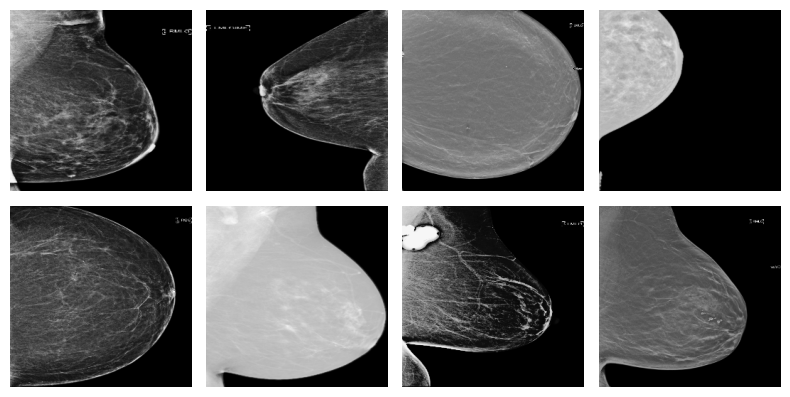

In [5]:
import matplotlib.pyplot as plt
def unscale_to_0_1(tensor):
    """
    Maps a tensor from [-1, 1] → [0, 1] for visualization.
    Args:
        tensor: (Tensor) Input tensor with values in [-1, 1].
    Returns:
        (Tensor) Output tensor with values in [0, 1].
    """
    return (tensor + 1) / 2

# img_batch has shape (B, 1, H, W)
B = img_batch.shape[0]

plt.figure(figsize=(8, 8))
for i in range(B):
    plt.subplot(4, 4, i+1) # Make a square grid
    plt.axis('off')
    plt.imshow(unscale_to_0_1(img_batch[i, 0].cpu()), cmap='gray', vmin=0, vmax=1)

plt.tight_layout()
plt.show()


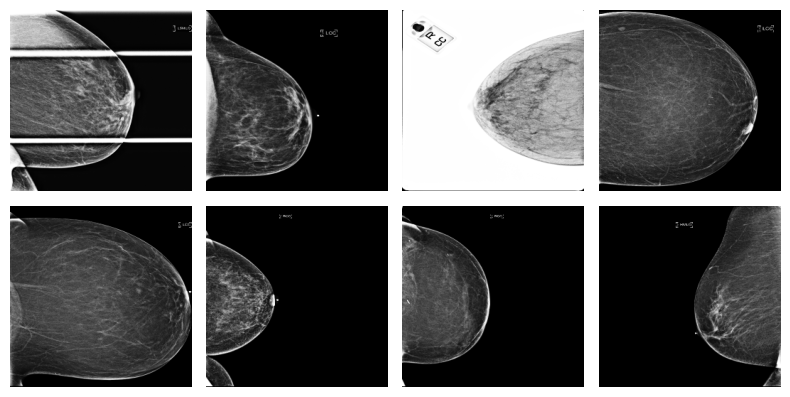

In [16]:
import matplotlib.pyplot as plt
def unscale_to_0_1(tensor):
    """
    Maps a tensor from [-1, 1] → [0, 1] for visualization.
    Args:
        tensor: (Tensor) Input tensor with values in [-1, 1].
    Returns:
        (Tensor) Output tensor with values in [0, 1].
    """
    return (tensor + 1) / 2

# img_batch has shape (B, 1, H, W)
B = img_batch.shape[0]

plt.figure(figsize=(8, 8))
for i in range(B):
    plt.subplot(4, 4, i+1) # Make a square grid
    plt.axis('off')
    plt.imshow(unscale_to_0_1(img_batch[i, 0].cpu()), cmap='gray', vmin=0, vmax=1)

plt.tight_layout()
plt.show()


# Load the model!!

In [3]:

# ----------------------------------------------------------------------
# 2. MODEL: resume checkpoint or fresh start
# ----------------------------------------------------------------------

def find_latest_ckpt(exp_dir):
    """Return newest .ckpt file inside <exp_dir>/checkpoints (or None)."""
    ckpt_dir = exp_dir / "checkpoints"
    if not ckpt_dir.is_dir():
        return None
    ckpts = list(ckpt_dir.glob("*.ckpt"))
    if not ckpts:
        return None
    # sort by modification time, newest first
    ckpts.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return ckpts[0]

resume_ckpt = find_latest_ckpt(experiment_path)
if resume_ckpt:
    print(f"🔄  resuming from checkpoint: {resume_ckpt}")
    if config["conditional"]:
        model = MonaiDDPM.load_from_checkpoint(resume_ckpt)
    else:
        model = MonaiDDPM_unconditional.load_from_checkpoint(resume_ckpt)
else:
    print("🆕  no checkpoint found – starting from scratch")
    if config["conditional"]:
        model = MonaiDDPM(lr=learning_rate, T=1000)
    else:
        model = MonaiDDPM_unconditional(lr=learning_rate, T=1000)

# Set up lightning functionalities

In [4]:

# ----------------------------------------------------------------------
# 3.  LIGHTNING TRAINER
# ----------------------------------------------------------------------

# Set up callbacks
tb_logger = pl_loggers.TensorBoardLogger('logs/', name=experiment_name)

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(experiment_path, "checkpoints"),
    filename=f"{{epoch:02d}}-{{step}}",
    auto_insert_metric_name=True,
    save_top_k=1,
    monitor="train_loss",
    mode="min",
)
early_stopping = EarlyStopping(
    monitor="train_loss",
    patience=15,
    mode="min",
    check_on_train_epoch_end=True,
)
lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Set up Trainer
trainer = pl.Trainer(
    fast_dev_run=False,
    max_epochs=num_epochs,
    accelerator="auto",
    precision=16,
    logger=tb_logger,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    gradient_clip_val=1.0,
    accumulate_grad_batches=4,
    **({"resume_from_checkpoint": resume_ckpt} if resume_ckpt else {})
    )



/home/locolinux2/miniconda3/envs/U24/lib/python3.9/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


# Do the training

In [5]:

trainer.fit(model, train_dataloaders=train_loader)

print('Training complete!')



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | unet      | DiffusionModelUNet | 18.5 M | train
1 | scheduler | DDPMScheduler      | 0      | train
---------------------------------------------------------
18.5 M    Trainable params
0         Non-trainable params
18.5 M    Total params
74.004    Total estimated model params size (MB)
203       Modules in train mode
0         Modules in eval mode
/home/locolinux2/miniconda3/envs/U24/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_steps=1` reached.


Training complete!
